# Example Application of Equity Methods to Semarang, Indonesia
Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import hydromt
import folium
import contextily as cx
import seaborn as sns
import rioxarray as rio
from fiat_toolbox.well_being.methods import equity_weight
from fiat_toolbox.well_being import Household

# paths to folders
pdir = r'p:\archivedprojects_tmp\11210264-001-just-equitable-paths\Case studies\FloodAdaptSemarang'
floodadaptdir = pdir + '/' + r'Database\Semarang_NEW\output\scenarios\2045_CMIP6_SSP2_4.5_Current_Demo1\Impacts'


## 1. Input Data
### 1.1 Damages Data
Read floodadapt data

In [2]:
# floodadapt data
# disaggregated data at the building level
dis_impacts = gpd.read_file(
    floodadaptdir + '/' + 'Impacts_building_footprints_2045_CMIP6_SSP2_4.5_Current_Demo1.gpkg',
    columns=['Primary Object Type', 'Object ID', 'Total Damage','Max Potential Damage: Structure', 'Damage: Structure', 'geometry'])

# only keep residential buildings
dis_impacts = dis_impacts[dis_impacts['Primary Object Type'] == 'residential'].copy()
dis_impacts = dis_impacts.drop(columns=['Primary Object Type'])

# number of people at the building level from FIAT input data
exposure = pd.read_csv(
    pdir + r'\Database\Semarang_NEW\static\templates\fiat\exposure\exposure.csv',
    usecols=['Object ID', 'People'])

# merge disaggregated impacts with exposure data
dis_impacts = dis_impacts.merge(exposure, on='Object ID', how='left')

# aggregated data at the village level
agg_impacts = gpd.read_file(floodadaptdir + '/' + 'Impacts_aggregated_2045_CMIP6_SSP2_4.5_Current_Demo1_DESA.gpkg')
print(len(agg_impacts))

currency = 'IDR'

# drop columns not needed
agg_impacts.drop(columns=['ResidentialMajorCount', 'ResidentialDestroyedCount', 'FloodedLowVulnerability',
                          'FloodedHighVulnerability', 'DisplacedLowVulnerability', 'DisplacedHighVulnerability'],
                          inplace=True)

# we will work on this crs and reproject the other files to this crs epsg=3857
crs_utm = agg_impacts.crs

# convert column names from Indonesian to English
language_dict = {
    'PROVNO': 'provinceNo',
    'KABKOTNO': 'regencyCityNo',
    'KECNO': 'KECNO', # not district number because same number corresponds to different ones
    'DESANO': 'villageNo',
    'PROVINSI': 'province',
    'KABKOT': 'regencyCity',  
    'KECAMATAN': 'district',
    'DESA': 'village',
    'IDDESA': 'villageID',
    'Luas_Desa': 'villageArea'  # which units?
}

'''
1st level: Provinces (Provinsi)
2nd level: Regencies (Kabupaten) and cities (Kota) (Kab/Kot)
3rd level: Districts (Kecamatan, Distrik, Kapanewon)
4th level: Villages (Desa) and Urban communities (Kelurahan)
'''

# map column names
agg_impacts.rename(columns=language_dict, inplace=True)
agg_impacts['villageID'] = agg_impacts['villageID'].astype('Int64')

village_boundaries = agg_impacts[['village', 'villageID', 'geometry']].copy()

agg_impacts.head(3)


236


provinceNo regencyCityNo KECNO villageNo     province regencyCity  district  \
0         33            21    10         1  JAWA TENGAH       DEMAK  MRANGGEN   
1         33            21    10         2  JAWA TENGAH       DEMAK  MRANGGEN   
2         33            21    10         3  JAWA TENGAH       DEMAK  MRANGGEN   

       village   villageID  villageArea  TotalDamageEvent  \
0  BANYUMENENG  3321010001   3589696.88      0.000000e+00   
1    SUMBEREJO  3321010002    963432.80      4.897375e+06   
2   KEBONBATUR  3321010003   4270594.80      1.388191e+11   

                                            geometry  
0  MULTIPOLYGON (((444991.747 9218738.926, 444899...  
1  MULTIPOLYGON (((445095.991 9214964.924, 445096...  
2  MULTIPOLYGON (((446274.81 9220520.238, 446259....

Merge the aggregated damages data with the disaggregated damages data as the assets and the asset damages is missing in the aggregated damages data. Only the total damages are available in the aggregated data.

In [3]:
joined = gpd.sjoin(dis_impacts, agg_impacts, how='left', predicate='within')

agg = joined.groupby('villageID', as_index=False)[['People','Total Damage','Damage: Structure', 'Max Potential Damage: Structure']].sum()

agg_impacts = agg_impacts.merge(agg, on='villageID', how='left')

agg

villageID  People  Total Damage  Damage: Structure  \
0    3321010001    7459  0.000000e+00       0.000000e+00   
1    3321010003   19373  1.372819e+11       9.690487e+10   
2    3321010004    8979  0.000000e+00       0.000000e+00   
3    3321010006    9960  0.000000e+00       0.000000e+00   
4    3321010007   14017  7.202840e+10       5.084358e+10   
..          ...     ...           ...                ...   
214  3374160006   18422  2.147076e+09       1.515583e+09   
215  3374160007   13134  1.572585e+09       1.110060e+09   
216  3374160008   18222  0.000000e+00       0.000000e+00   
217  3374160009    8091  0.000000e+00       0.000000e+00   
218  3374160010   19853  2.694195e+10       1.901785e+10   

     Max Potential Damage: Structure  
0                       4.460714e+11  
1                       7.930006e+11  
2                       6.924204e+09  
3                       1.190175e+11  
4                       3.359855e+11  
..                               ...  
214                     1.352112e+12  
215                     9.973667e+11  
216                     1.305018e+12  
217                     2.342381e+11  
218                     1.787980e+12  

[219 rows x 5 columns]

### Function for plots

In [4]:
def improve_axis(ax):
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    cx.add_basemap(ax=ax, crs=crs_utm, source=cx.providers.CartoDB.Positron)
    agg_impacts.boundary.plot(ax=ax, color='grey', lw=0.5)


### 1.2 Socioeconomic Data
#### Read socioeconomic data
- Poverty Rate using National Poverty Line (NPL) -> FGT0 = Number of poor people / Total population,
- Standard Error of FGT0
- Poverty Gap using National Poverty Line (NPL) -> FGT1 = (NPL - Per capita expenditure) / NPL*Total population,
- Standard Error of FGT
- Poverty Severity -> FGT2 = Square of FGT1
- Standard Error of FGT2
- Poverty Rate using International Poverty Line (US$3.1 PPP) -> FGT0 = Number of poor people / Total population,
- Standard Error of FGT0
- Poverty Gap using International Poverty Line (US$3.1 PPP) -> FGT1 = (IPL - Per capita expenditure) / IPL*Total population,
- Standard Error of FGT1
- Poverty Severity -> FGT2 = Square of FGT1
- Standard Error of FGT2
- Gini Index
- Standard Error of Gini Index

In [5]:
# socio economic data available at village (desa) level only
povmap = pd.read_excel(
    pdir + '/' + 'povmap_2015.xlsx',
    usecols=['des', 'nmdesa', 'p0_gkn', 'se_p0_gkn', 'p1_gkn', 'se_p1_gkn', 'p2_gkn', 'se_p2_gkn', 'p0_intl',
             'se_p0_intl', 'p1_intl', 'se_p1_intl', 'p2_intl', 'se_p2_intl', 'gini', 'se_gini'])

povlegend = pd.read_excel(pdir + '/' + 'variable_2015.xlsx')
# only keep legend for poverty variables
povlegend = povlegend.loc[31:,:]

# keep poverty indices only for the village (desa) that are present in the floodadapt data
villages_impacts = list(np.unique(agg_impacts.villageID))  
villages_pov = list(np.unique(povmap.des)) 
villages_ids = list(set(villages_impacts) & set(villages_pov)) 

# filter povmap
povmap = povmap[povmap['des'].isin(villages_ids)]

#### Plot poverty data

<Axes: title={'center': 'poverty values for villages'}, xlabel='values', ylabel='columns'>

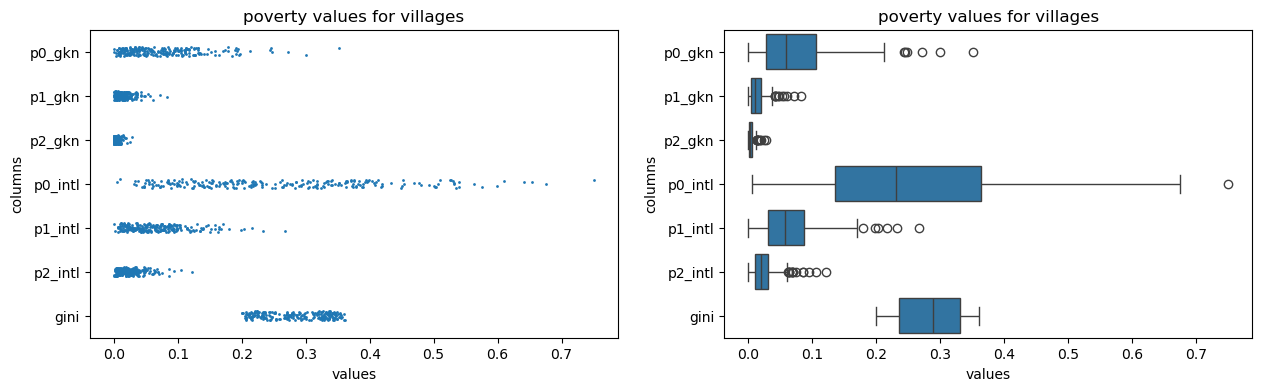

In [6]:
# explore poverty data
povvars = ['p0_gkn', 'p1_gkn', 'p2_gkn', 'p0_intl', 'p1_intl', 'p2_intl', 'gini']

df_melt = povmap.melt(id_vars='des', value_vars=povvars, var_name='columns', value_name='values')

fig, ax = plt.subplots(1,2,figsize=(15, 4))
ax[0].set_title('poverty values for villages')
sns.stripplot(data=df_melt, ax=ax[0], x='values', y='columns', jitter=True, size=2)

ax[1].set_title('poverty values for villages')
sns.boxplot(data=df_melt, ax=ax[1], x='values', y='columns')

#### Merge socioeconomic data with damages data at the village level

number of villages 235 and are unique: True


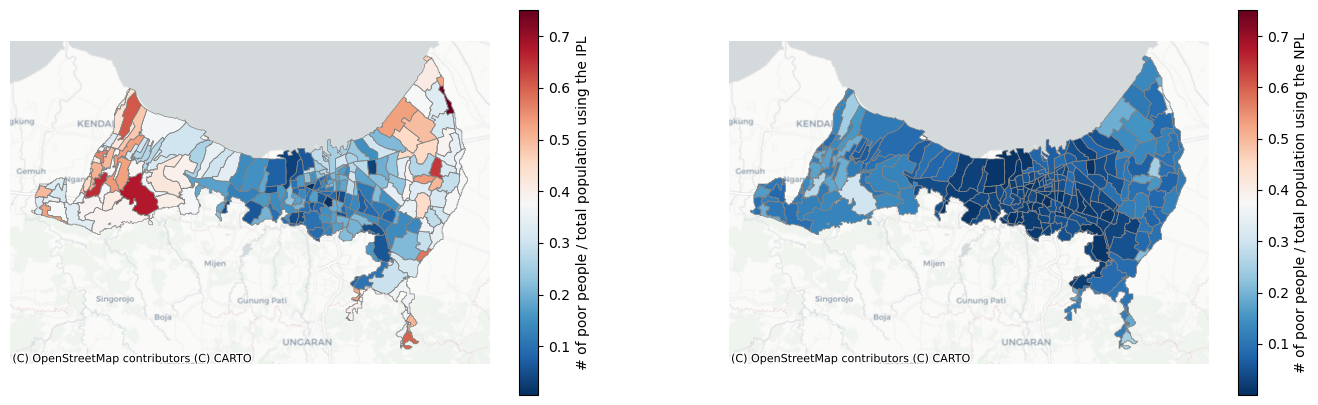

In [7]:
# add poverty variables to impacts dataframe
int_pov_var = 'p0_intl'
nat_pov_var = 'p0_gkn'

# merge poverty data with aggregated impacts
agg_impacts = pd.merge(
    agg_impacts,
    povmap[['des', int_pov_var, nat_pov_var]],
    left_on='villageID',
    right_on='des')

print(f'number of villages {len(agg_impacts.villageID)} and are unique: {agg_impacts["villageID"].is_unique}')

# use same cmax value
vmax = max(agg_impacts[int_pov_var].max(), agg_impacts[nat_pov_var].max())

# plot poverty variables on map
cmap = 'RdBu_r'
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
agg_impacts.plot(
    ax=ax[0],
    column=int_pov_var,
    cmap=cmap,
    vmax=vmax,
    legend=True,
    legend_kwds={"label": f"# of poor people / total population using the IPL"}
    )
improve_axis(ax[0])

# fig, ax = plt.subplots(figsize=(10, 5))
agg_impacts.plot(
    ax=ax[1],
    column=nat_pov_var,
    cmap=cmap,
    vmax=vmax,
    legend=True,
    legend_kwds={"label": f"# of poor people / total population using the NPL"}
    )
improve_axis(ax[1])

## 2. Relative Loss

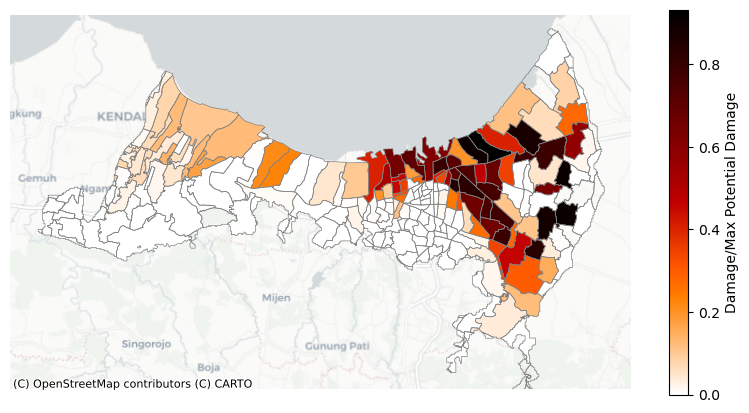

In [8]:
asset_damages = 'Damage: Structure'
asset_value = 'Max Potential Damage: Structure'
agg_impacts['relative_damages'] = agg_impacts[asset_damages] / agg_impacts[asset_value]

cmap = 'gist_heat_r'

fig, ax = plt.subplots(figsize=(10, 5))
agg_impacts.plot(column='relative_damages', ax=ax, cmap=cmap, legend=True,
                 legend_kwds={"label": f"Damage/Max Potential Damage"})
improve_axis(ax)

## 3. Vulnerability assessment

In [9]:
import folium
from ipywidgets import FloatSlider, VBox
from IPython.display import display, clear_output

# get center
minx, miny, maxx, maxy = village_boundaries.to_crs("EPSG:4326").geometry.total_bounds
lon = (minx + maxx) /2
lat = (miny + maxy) / 2

map_center = [lat, lon]


# Function to update folium map based on slider input
def update_map(pov_bin_val, rel_dam_bin_val):
    clear_output(wait=True)  # clear previous output

    # Create base map
    f = folium.Figure(width=700, height=400)
    m = folium.Map(location=map_center, tiles="openstreetmap", zoom_start=11).add_to(f)

    # Filter polygons
    filtered = agg_impacts[
        (agg_impacts[int_pov_var] >= pov_bin_val)
        ]
    filtered = filtered[
        (agg_impacts['relative_damages'] >= rel_dam_bin_val)
    ]
    
    # Add polygons to map
    if not filtered.empty:
        folium.GeoJson(
            filtered,
            style_function=lambda x: {
                'fillColor': 'orange',
                'color': 'black',
                'weight': 1,
                'fillOpacity': 0.6
            },
            name="Filtered Polygons"
        ).add_to(m)
    

    def style_fn(x):
        return {'color': 'black',
                'weight': 1,
                'fillOpacity': 0}

    
    folium.GeoJson(
        agg_impacts,
        style_function=style_fn,
        popup=folium.GeoJsonPopup(agg_impacts.drop(columns=["geometry"]).columns.tolist()),
        tooltip=folium.GeoJsonTooltip(
            fields=['village','villageID', int_pov_var, 'relative_damages'])
    ).add_to(m)

    display(m)
    display(VBox([pov_slider, rel_dam_slider]))

pov_slider = FloatSlider(min=0, max=1, step=0.2, value=0.2, description="poverty_bin", style={'description_width': 'initial'})
rel_dam_slider = FloatSlider(min=0, max=1, step=0.2, value=0.2, description="relative_damage_bin", style={'description_width': 'initial'})

# Connect sliders to update_map function
def on_slider_change(change):
    update_map(pov_slider.value, rel_dam_slider.value)

# Observe slider changes
pov_slider.observe(on_slider_change, names="value")
rel_dam_slider.observe(on_slider_change, names="value")

# Initial display
update_map(pov_slider.value, rel_dam_slider.value)

## 4. Compute Equity Weighted Damages
Instead of income we will use a poverty variable. We need to convert the 'negative' poverty variable into a 'positive' variable. Then, we can compute the weighted average, the equity weights and lastly, the equity weighted damages. Note: we are using the total damages.

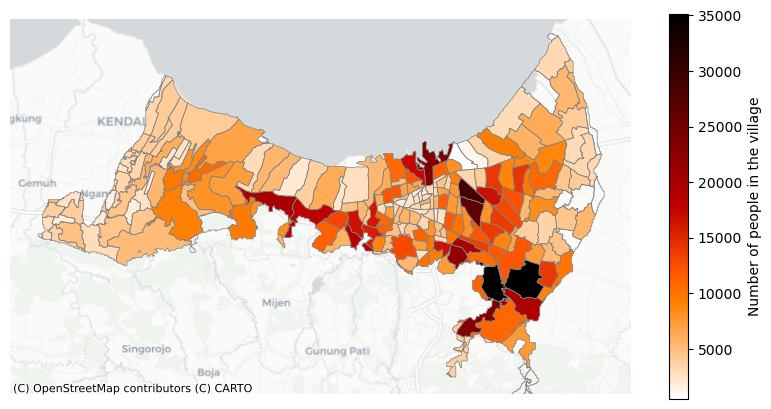

In [10]:
cmap = 'gist_heat_r'

fig, ax = plt.subplots(figsize=(10, 5))
agg_impacts.plot(column='People', ax=ax, cmap=cmap, legend=True,
                 legend_kwds={"label": f"Number of people in the village"})
improve_axis(ax)

# replace the nan by 0, otherwise the equity weights will give NaN values
agg_impacts['People'].fillna(0, inplace=True)

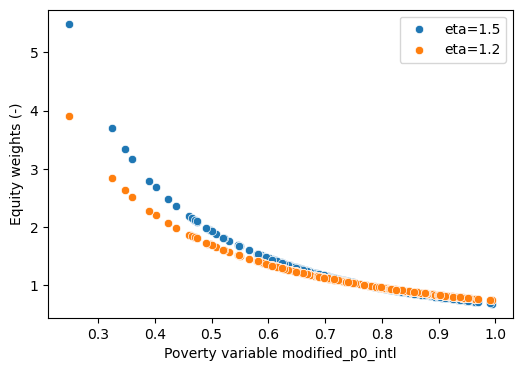

In [11]:
# instead of number of poor people/tot pop, we convert to number of non-poor people/tot pop
pov_var_mod = f'modified_{int_pov_var}'
agg_impacts[pov_var_mod] = 1 - agg_impacts[int_pov_var]

# compute the weighted average
avg_pov = np.average(agg_impacts[pov_var_mod], weights=agg_impacts['People'])

# use equity weights function from fiat_toolbox
# compute equity weights for eta=1.5 and eta=1.2
agg_impacts['EW_15'] = agg_impacts.apply(lambda row: equity_weight(row[pov_var_mod], avg_pov, 1.5), axis=1)
agg_impacts['EW_12'] = agg_impacts.apply(lambda row: equity_weight(row[pov_var_mod], avg_pov, 1.2), axis=1)

# verify that the EW make sense for two different values of eta
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(ax=ax, data=agg_impacts, x=pov_var_mod, y='EW_15', label='eta=1.5')
sns.scatterplot(ax=ax, data=agg_impacts, x=pov_var_mod, y='EW_12', label='eta=1.2')
ax.set_ylabel('Equity weights (-)')
ax.set_xlabel(f'Poverty variable {pov_var_mod}')
plt.legend()

damages = 'TotalDamageEvent'
# compute equity weighted damages
agg_impacts['EW_15_damages'] = agg_impacts[damages] * agg_impacts['EW_15']
agg_impacts['EW_12_damages'] = agg_impacts[damages] * agg_impacts['EW_12']


Plot equity weighted total damages

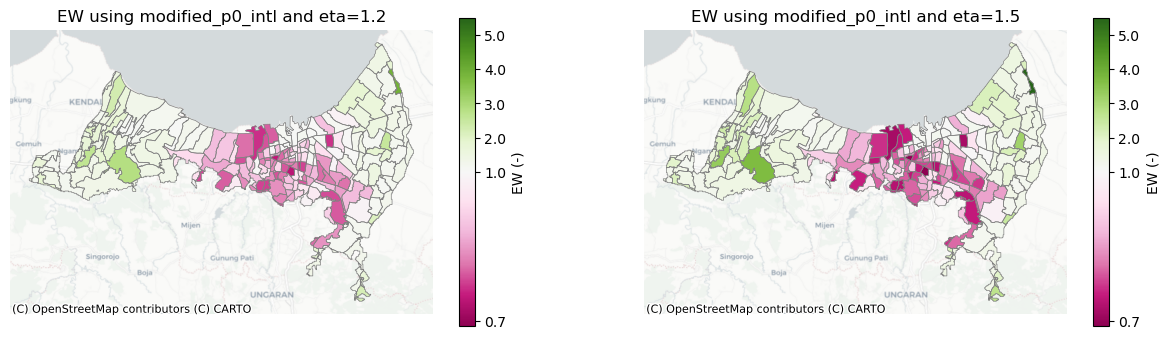

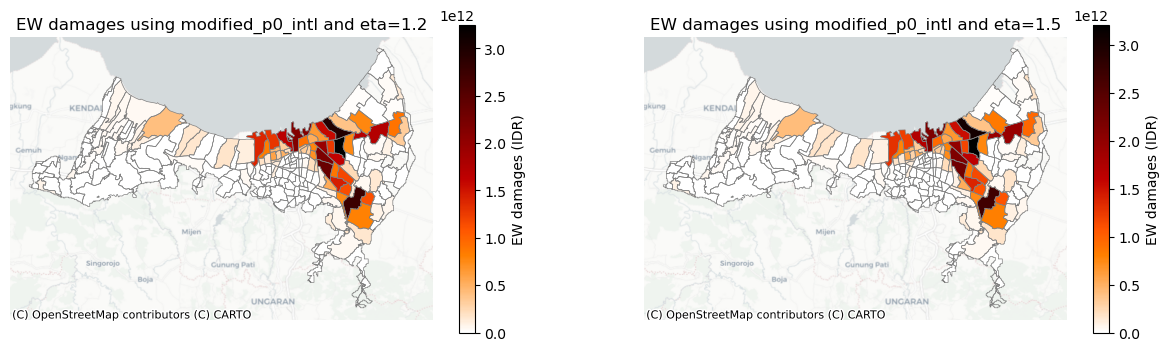

In [12]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

figsize =(15, 4)

# normalize colorbar for EW center around 1
vmin = min(agg_impacts['EW_12'].min(), agg_impacts['EW_15'].min())
vmax = max(agg_impacts['EW_12'].max(), agg_impacts['EW_15'].max())
boundaries = [round(vmin,1), 1, 2, 3, 4, 5, round(vmax,1)]
cmap_EW = 'PiYG'
norm = TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)

# visualize equity weights
fig, ax = plt.subplots(1, 2, figsize=figsize)
ax[0].set_title(f'EW using {pov_var_mod} and eta=1.2')
agg_impacts.plot(ax=ax[0], column='EW_12', cmap=cmap_EW, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap_EW, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax[0], ticks=boundaries)
cbar.set_label('EW (-)')
improve_axis(ax[0])

ax[1].set_title(f'EW using {pov_var_mod} and eta=1.5')
agg_impacts.plot(ax=ax[1], column='EW_15', cmap=cmap_EW, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap_EW, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax[1], ticks=boundaries)
cbar.set_label('EW (-)')
improve_axis(ax[1])

# visualize equity weighted damages
fig, ax = plt.subplots(1, 2, figsize=figsize)

ax[0].set_title(f'EW damages using {pov_var_mod} and eta=1.2')
agg_impacts.plot(ax=ax[0], column='EW_12_damages', cmap=cmap, legend=True, legend_kwds={"label": f"EW damages ({currency})"})
improve_axis(ax[0])

ax[1].set_title(f'EW damages using {pov_var_mod} and eta=1.5')
agg_impacts.plot(ax=ax[1], column='EW_15_damages', cmap=cmap, legend=True, legend_kwds={"label": f"EW damages ({currency})"})
improve_axis(ax[1])

Compare total damages with equity weighted damages

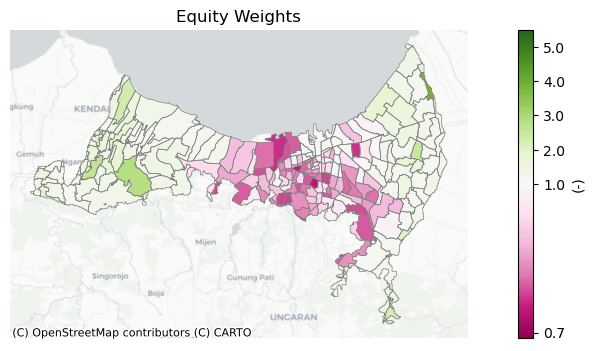

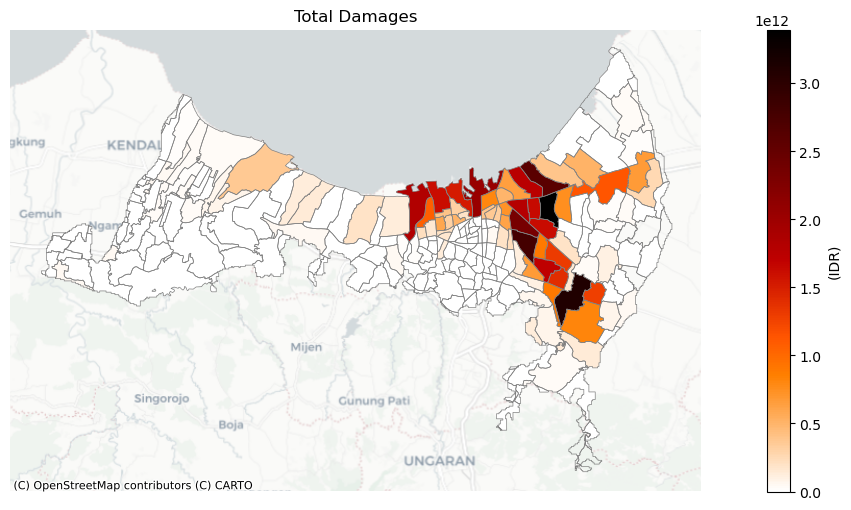

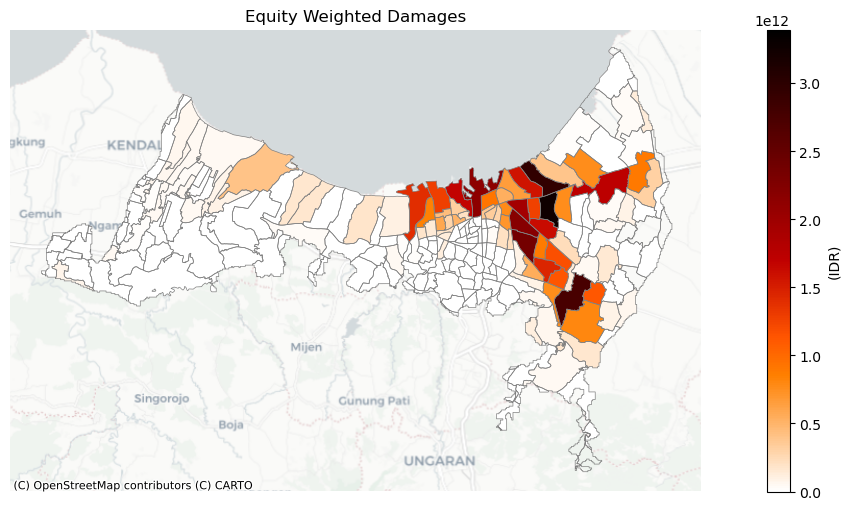

In [13]:
figsize = (17, 6)

fig, ax = plt.subplots(1, 1, figsize=(13, 4))
ax.set_title(f'Equity Weights')
agg_impacts.plot(ax=ax, column='EW_12', cmap=cmap_EW, norm=norm)
sm = plt.cm.ScalarMappable(cmap=cmap_EW, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, ticks=boundaries)
cbar.set_label('(-)')
improve_axis(ax)

cbarmax = max(agg_impacts['TotalDamageEvent'].max(), agg_impacts['EW_12_damages'].max())

fig, ax = plt.subplots(figsize=figsize)
ax.set_title(f'Total Damages')
agg_impacts.plot(
    ax=ax,
    column='TotalDamageEvent',
    cmap=cmap,
    vmax=cbarmax,
    legend=True,
    legend_kwds={"label": f"({currency})"}
    )
improve_axis(ax)

fig, ax = plt.subplots(figsize=figsize)
ax.set_title(f'Equity Weighted Damages')
agg_impacts.plot(
    ax=ax,
    column='EW_12_damages',
    cmap=cmap,
    vmax=cbarmax,
    legend=True,
    legend_kwds={"label": f"({currency})"}
    )
improve_axis(ax)

## 5. Wellbeing Method

Configurations

In [14]:
pi = 2654915 / 14083079 # productivity for year 2015 
eta = 1.5  # elasticity of marginal utility of income
rho = 0.05  # discount rate
t_max = 10  # maximum time horizon in years
dt = 1 / 52 # weekly time step

### 5.1 Income Data

Based on the poverty variables, we can create 3 income brackets: from 0 to $2.15, from $2.15 to $3.1 and from $3.1 to upper boundary
based on p0_gkn and p0_intl and using average income population (at a more aggregated level). The obtained income will be used as the predisaster consumption.

<!-- 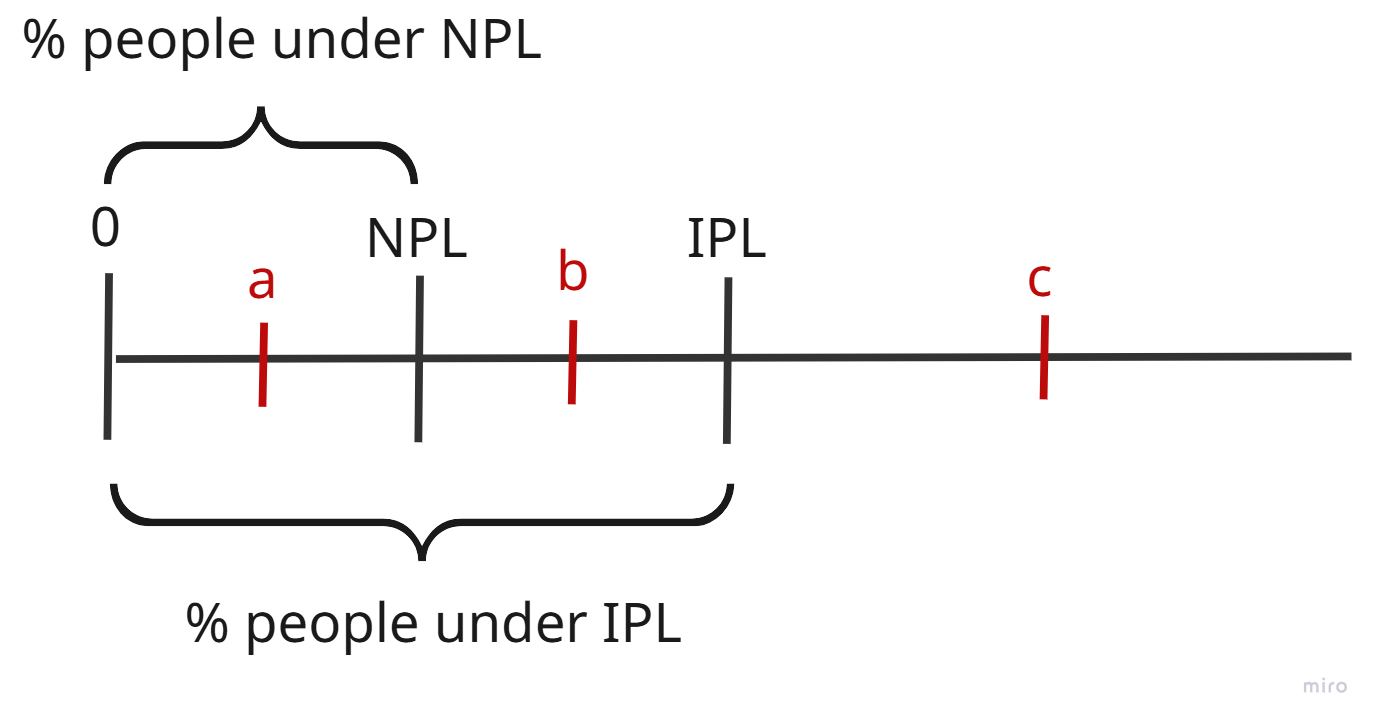 -->
<img src="income.jpg" width="400"/>

In [15]:
conv_factor = 16536.14  # IDR/$
npl = 2.15 * 365 * conv_factor # IDR/year/person
ipl = 3.1 * 365 * conv_factor # IDR/year/person

# we assume average income to be 400 dollars per month per year? and from that we back calculate c
avg_inc = 400 * 12  * conv_factor # IDR/year/person
summed_inc = avg_inc * agg_impacts['People'].sum()

"""
yearly_income,i = ax + b(y,i-x,i) + c(1-y,i)
summed_income = sum (pop,i * yearly_income,i)
summed_income = a * sum(pop,i * x,i) + b * sum(pop,i (y,i - x,i)) + c * sum(pop,i (1-y,i))
c = (summed_income - a * sum(pop,i * x,i) - b * sum(pop,i (y,i - x,i))) / (sum(pop,i (1-y,i)))

"""
a = (0 + npl) / 2
b = (npl + ipl) / 2
A = (agg_impacts['People'] * agg_impacts[nat_pov_var])
B = (agg_impacts['People'] * (agg_impacts[int_pov_var] - agg_impacts[nat_pov_var]))
C = (agg_impacts['People'] * (1 - agg_impacts[int_pov_var]))

c = (summed_inc - a * A.sum() - b * B.sum() ) / C.sum()

# calculate yearly income per village
agg_impacts['yearly_income'] = a * A + b * B + c * C


Subtract the minimum consumption from the income to obtain available consumption. Ask Vanni for link. Table from link is:

<img src="MonthlyAvgExpenditureperCapita.png" width="500"/>

In [16]:
# monthly cmin per capita per income group IDR/month/person
cmin_a = 734292
cmin_b = 1608554
cmin_c = 4270814

#INCOME DATA
income_data = agg_impacts.copy()

income_data = income_data.assign(
    nat_idr=a, intl_idr=b, high_idr=c,
    nat_people=A, intl_people=B, high_people=C
)[['People', 'nat_idr', 'intl_idr', 'high_idr', 'nat_people', 'intl_people', 'high_people']]

# Compute sums and means as before
sums = income_data[['People', 'nat_people', 'intl_people', 'high_people']].sum()
means = income_data[['nat_idr', 'intl_idr', 'high_idr']].mean()


# Combine into one Series
income_data = pd.concat([sums, means])

nat_pct = income_data['nat_people'] / income_data['People'] * 100
intl_pct = income_data['intl_people'] / income_data['People'] * 100

income_data = pd.DataFrame({
    'low': [0.0, nat_pct, nat_pct + intl_pct],
    'high': [nat_pct, nat_pct + intl_pct, 100.0],
    'median_value': [
        income_data['nat_idr'], 
        income_data['intl_idr'], 
        income_data['high_idr']
    ]
})

income_data

low        high  median_value
0   0.000000    6.127931  6.488368e+06
1   6.127931   22.437977  1.584369e+07
2  22.437977  100.000000  9.849119e+07

In [17]:
#CONSUMPTION DATA
cmin_data = pd.DataFrame({
    'low': [0.00, 40.00, 80.00],
    'high': [40.00, 80.00, 100.00],
    'median_value': [734292*12, 1608554*12, 4270814*12]
})

cmin_data

low   high  median_value
0   0.0   40.0       8811504
1  40.0   80.0      19302648
2  80.0  100.0      51249768

In [18]:
#assuming the range is median, and equally distributed, get relation between income and consumption


def calculate_area_and_point(range_data):
    # Calculate 'area'
    range_data['area'] = range_data['median_value'] * (
        range_data['high'] - range_data['low']
    )

    # Initialize the column with zeros
    range_data['value_at'] = 0.0

    # Loop through rows to calculate 'point'
    for i in range(len(range_data)):
        delta_c = (
            range_data.at[i, 'high'] -
            range_data.at[i, 'low']
        )
        value = (range_data.at[i, 'area'] / delta_c) * 2 if delta_c != 0 else 0
        if i == 0:
            range_data.at[i, 'value_at'] = value
        else:
            range_data.at[i, 'value_at'] = value - range_data.at[i - 1, 'value_at']

    # Optional: Format numbers with commas for easier reading
    range_data['area'] = range_data['area'].map('{:,.2f}'.format)
    range_data['value_at'] = range_data['value_at'].map('{:,.0f}'.format)

    range_data = range_data[['high', 'value_at']]
    range_data = range_data.rename(columns={'high': 'population_perc', 'value_at': 'value'})
    range_data = pd.concat([pd.DataFrame({'population_perc': [0.0], 'value': [0.0]}), range_data], ignore_index=True)
                           
    return range_data



income = calculate_area_and_point (income_data)
cmin = calculate_area_and_point (cmin_data)


print (cmin)
print (income)

   population_perc       value
0              0.0         0.0
1             40.0  17,623,008
2             80.0  20,982,288
3            100.0  81,517,248
   population_perc        value
0         0.000000          0.0
1         6.127931   12,976,736
2        22.437977   18,710,642
3       100.000000  178,271,729


In [19]:
cmin = cmin.rename(columns={'value': 'consumption'})
income = income.rename(columns={'value': 'income'})

for df, cols in [(cmin, ['consumption', 'population_perc']), (income, ['income', 'population_perc'])]:
    for col in cols:
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)


dpop_perc = np.arange(0, 101.0, 10.0)
ratio = pd.DataFrame({'population_perc': dpop_perc})
ratio['cmin'] = np.interp(ratio['population_perc'], cmin['population_perc'], cmin['consumption'])
ratio['income'] = np.interp(ratio['population_perc'], income['population_perc'], income['income'])
ratio['cmin_per_income'] = np.where(ratio['income'] == 0, 0, ratio['cmin'] / ratio['income'])


print (ratio)

    population_perc        cmin        income  cmin_per_income
0               0.0         0.0  0.000000e+00         0.000000
1              10.0   4405752.0  1.433799e+07         0.307278
2              20.0   8811504.0  1.785355e+07         0.493543
3              30.0  13217256.0  3.426728e+07         0.385711
4              40.0  17623008.0  5.483935e+07         0.321357
5              50.0  18462828.0  7.541141e+07         0.244828
6              60.0  19302648.0  9.598347e+07         0.201104
7              70.0  20142468.0  1.165555e+08         0.172814
8              80.0  20982288.0  1.371276e+08         0.153013
9              90.0  51249768.0  1.576997e+08         0.324983
10            100.0  81517248.0  1.782717e+08         0.457264


In [20]:
print (agg_impacts.columns)


agg_impacts['yearly_income_per_capita'] = agg_impacts['yearly_income']/agg_impacts['People']

agg_impacts['ratio_cmin_per_income_per_capita'] = np.interp(
    agg_impacts['yearly_income_per_capita'],
    ratio['income'],
    ratio['cmin_per_income']
)

agg_impacts ['cmin_ratio_based'] = agg_impacts['ratio_cmin_per_income_per_capita'] * agg_impacts['yearly_income_per_capita']

Index(['provinceNo', 'regencyCityNo', 'KECNO', 'villageNo', 'province',
       'regencyCity', 'district', 'village', 'villageID', 'villageArea',
       'TotalDamageEvent', 'geometry', 'People', 'Total Damage',
       'Damage: Structure', 'Max Potential Damage: Structure', 'des',
       'p0_intl', 'p0_gkn', 'relative_damages', 'modified_p0_intl', 'EW_15',
       'EW_12', 'EW_15_damages', 'EW_12_damages', 'yearly_income'],
      dtype='object')


count    2.190000e+02
mean     1.865892e+07
std      7.893298e+05
min      1.302919e+07
25%      1.849728e+07
50%      1.879844e+07
75%      1.918301e+07
max      1.943699e+07
Name: cmin_ratio_based, dtype: float64

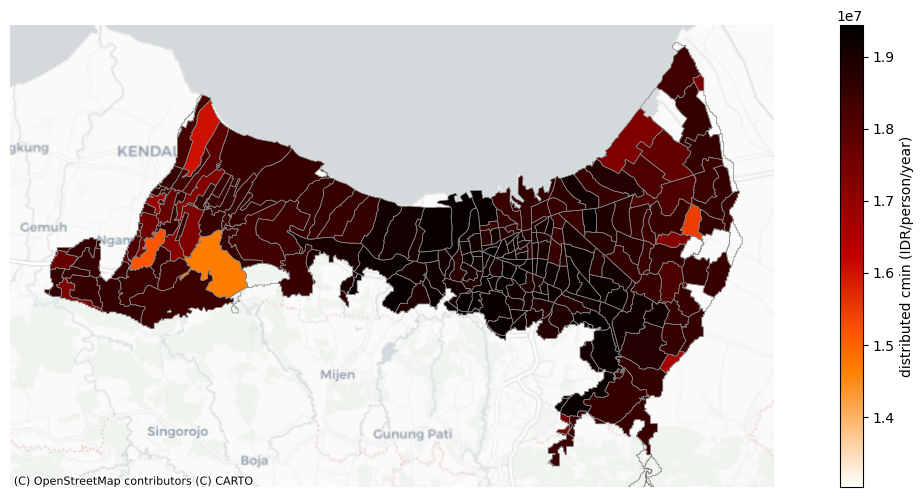

In [21]:
agg_impacts['cmin'] = npl


#agg_impacts['dist_cmin'] = (0.4 * A * 734292 + 0.4 * B * 1608554 + 0.2 * C * 4270814) * 12 #VANNI: changed because A B and C not the lowest 40% 
agg_impacts['dist_cmin'] = agg_impacts ['cmin_ratio_based']
agg_impacts[['cmin', 'dist_cmin']]

fig, ax = plt.subplots(1, 1, figsize=figsize)
agg_impacts.plot(
    ax=ax,
    column='dist_cmin',
    cmap=cmap,
    legend=True,
    legend_kwds={"label": f"distributed cmin (IDR/person/year)"}
)
improve_axis(ax)


agg_impacts['cmin_ratio_based'].describe()

Check that this gives reasonable results

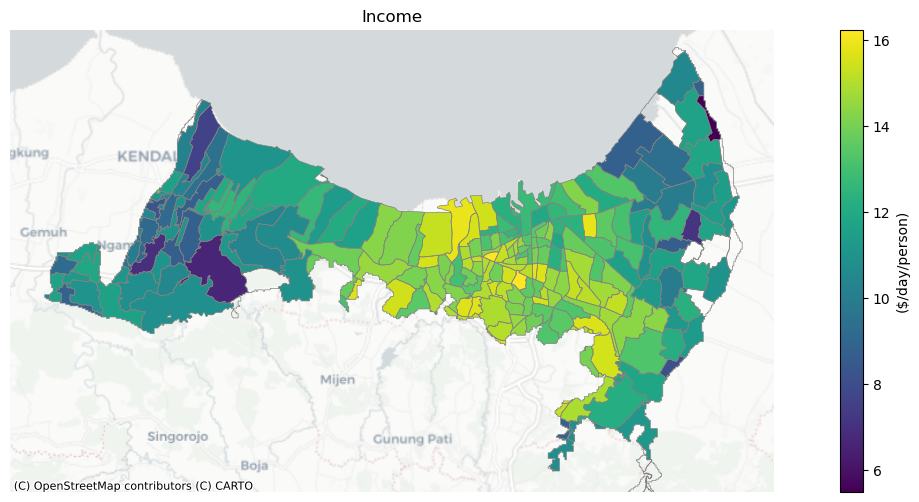

In [22]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Income')
agg_impacts['daily_per_capita_income'] = agg_impacts['yearly_income'] / 365 / agg_impacts['People'] / conv_factor
agg_impacts.plot(column='daily_per_capita_income', ax=ax, cmap='viridis', legend=True, legend_kwds={"label": f"($/day/person)"})
improve_axis(ax)

### 5.2 Per Household 

Instead of computing the losses per capita we compute them at the household level. For this we required the equivalised household size (see: https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Equivalised_disposable_income). In Jawa Tengah, where Semarang is located, there is an average of 3.7 people per household in 2016 (see: https://www.bps.go.id/en/statistics-table/2/MTQ4IzI=/average-household-size.html).

We can assume that there are 2 adults per household and either:
- both children under 14 or,
- one child under 14 and another one over 14 or,
- both children over 14

This gives according to the OECD scale:
- 1 * 1.0 + 1 * 0.5 + 2 * 0.3 = 2.1 to
- 1 * 1.0 + 1 * 0.5 + 2 * 0.5 = 2.5

If we then choose the median of the possible range, we get hh = 2.3

The minimum required consumption, cmin should then be also updated to be at the household level. Based on https://semarangkota.bps.go.id/en/statistics-table/1/NjgjMQ==/average-of-expenditure-per-capita-monthly-and-composition-of-consumption--2010---2014.html, we see that approx. 40% of the consumption is spent on food and the remaining 60% on non food.

cmin = (0.4 * pph + 0.6 non food * hh) * npl?



In [23]:
# equivalent household size
hh = 2.3
# average household size
pph = 3.7

# minimum consumption per village
agg_impacts['cmin'] = npl * agg_impacts['People']

# minimum consumption at village level
# agg_impacts['cmin_hh'] = (0.4 * agg_impacts['People'] + 0.6 * agg_impacts['People'] / pph) * npl
# agg_impacts['cmin_hh'] = agg_impacts['cmin'] / agg_impacts['People'] * hh

# yearly income at village level to at household level
# agg_impacts['yearly_income_hh'] = agg_impacts['yearly_income'] / agg_impacts['People'] * hh

num_rows = (agg_impacts['yearly_income'] - agg_impacts['cmin'] > 0).sum()
print(f"Number of rows where yearly_income - cmin > 0: {num_rows} out of {len(agg_impacts)}")

print(agg_impacts.loc[agg_impacts['yearly_income'] - agg_impacts['cmin'] <= 0, ['People']])
# probably due to population = 0 in some villages

Number of rows where yearly_income - cmin > 0: 219 out of 235
    People
1      0.0
10     0.0
16     0.0
18     0.0
19     0.0
32     0.0
37     0.0
38     0.0
39     0.0
40     0.0
41     0.0
42     0.0
45     0.0
56     0.0
85     0.0
95     0.0


In [24]:
print(avg_inc * agg_impacts['People'].sum())
weighted_average = np.average(agg_impacts['yearly_income'], weights=agg_impacts['People'])
print(weighted_average)

129364313388096.0
962350016102.4149


### 5.3 Apply Wellbeing Method
Instead of the total damages, we use the damages to the structure, the maximum value of the structure and the ratio of the latter two as the 'vulnerability'.

If villages cannot recover, just assume longest time (e.g. 10 years) 
TODO: It seems that the damages to structure are off?

In [25]:
from fiat_toolbox.well_being import Household
Household

# drop rows from agg_impacts where asset_damages = 0 or np.nan
filtered_impacts = agg_impacts[agg_impacts[asset_damages] > 0 ]  # len = 39

# now we can move on to the wellbeing method
losses = {}
objects = {}

for i, household in filtered_impacts.iterrows():
    id = household['villageID']
    # perhaps add village name (which can be repeated) as well?
    var = Household(v=household['relative_damages'],
                    k_str=household[asset_value],  # IPR/village
                    c0=household['yearly_income'],  # IPR/year/village
                    c_avg=weighted_average,  # IPR/year/person
                    pi=pi,
                    rho=rho,
                    t_max=t_max, 
                    currency=currency,
                    cmin=household['cmin'],  # IPR/year/village
                    recovery_per=95
                    )
    var.opt_lambda(eps_rel=0.0) 
    losses[id] = var.get_losses()
    objects[id] = var

losses = pd.DataFrame(losses)
print(losses[losses.index == 'Wellbeing Loss'].notna().sum(axis=1))
display(losses)

Wellbeing Loss    114
dtype: int64


3321010003    3321010007    3321010008    3321010009  \
Reconstruction Costs  9.691849e+10  5.085416e+10  5.309965e+11  3.208986e+11   
Income Loss           8.537727e+09  3.680699e+09  8.259385e+10  9.654702e+10   
Consumption Loss      1.054562e+11  5.453486e+10  6.135904e+11  4.174456e+11   
Utility Loss          9.455998e-08  7.463696e-08  1.934041e-07  1.296924e-06   
Wellbeing Loss        8.731415e+10  6.917933e+10  1.758302e+11  1.144399e+12   
Asset Loss            9.690487e+10  5.084358e+10  5.309755e+11  3.215056e+11   
Equity Weighted Loss  5.604843e+10  4.590164e+10  1.059789e+11  5.907233e+11   

                        3321010010    3321010011    3321010016    3321010017  \
Reconstruction Costs  5.370229e+09  6.931173e+10  4.189526e+09  1.969371e+08   
Income Loss           2.122062e+08  1.594570e+10  1.532090e+08  3.717910e+06   
Consumption Loss      5.582435e+09  8.525742e+10  4.342735e+09  2.006550e+08   
Utility Loss          3.830163e-08  1.477032e-06  3.406704e-08  1.312030e-09   
Wellbeing Loss        3.579136e+10  1.321598e+12  3.185807e+10  1.232509e+09   
Asset Loss            5.366480e+09  6.932945e+10  4.186111e+09  1.963364e+08   
Equity Weighted Loss  2.433865e+10  6.541209e+11  2.219122e+10  9.069040e+08   

                        3321010018    3321040001  ...    3374140016  \
Reconstruction Costs  2.522491e+10  1.565748e+10  ...  5.691122e+11   
Income Loss           2.691358e+09  1.282222e+09  ...  3.581359e+11   
Consumption Loss      2.791627e+10  1.693970e+10  ...  9.272482e+11   
Utility Loss          3.169922e-07  1.913434e-07  ...  3.642228e-06   
Wellbeing Loss        2.914173e+11  1.769442e+11  ...  3.062906e+12   
Asset Loss            2.522250e+10  1.565493e+10  ...  5.990638e+11   
Equity Weighted Loss  1.789963e+11  1.009167e+11  ...  1.302990e+12   

                        3374150001    3374150002    3374150003    3374150005  \
Reconstruction Costs  2.200452e+09  2.376620e+10  5.039510e+08  8.924367e+10   
Income Loss           7.610229e+07  1.589820e+09  9.513921e+06  1.601266e+10   
Consumption Loss      2.276554e+09  2.535602e+10  5.134649e+08  1.052563e+11   
Utility Loss          3.939521e-08  8.703319e-08  3.513218e-09  6.888935e-07   
Wellbeing Loss        3.685933e+10  8.077711e+10  3.300324e+09  6.230211e+11   
Asset Loss            2.198447e+09  2.376040e+10  5.024139e+08  8.924309e+10   
Equity Weighted Loss  2.694431e+10  5.653944e+10  2.524736e+09  3.527630e+11   

                        3374150006    3374150007    3374160006    3374160007  \
Reconstruction Costs  7.901381e+10  1.402371e+09  1.520220e+09  1.113456e+09   
Income Loss           1.319063e+10  3.547138e+07  2.869972e+07  2.102057e+07   
Consumption Loss      9.220444e+10  1.437842e+09  1.548920e+09  1.134477e+09   
Utility Loss          6.052881e-07  1.707048e-08  9.167607e-10  1.248906e-09   
Wellbeing Loss        5.489039e+11  1.600967e+10  8.612004e+08  1.173218e+09   
Asset Loss            7.901170e+10  1.399984e+09  1.515583e+09  1.110060e+09   
Equity Weighted Loss  3.098380e+11  1.162470e+10  6.680678e+08  8.946124e+08   

                        3374160010  
Reconstruction Costs  1.903621e+10  
Income Loss           6.397878e+08  
Consumption Loss      1.967600e+10  
Utility Loss          1.222029e-08  
Wellbeing Loss        1.143650e+10  
Asset Loss            1.901785e+10  
Equity Weighted Loss  8.397889e+09  

[7 rows x 114 columns]

Merge losses computed with geodataframe

In [26]:
from enum import Enum
# len(losses.columns) = 39 but 

losses = losses.T
loss_list = list(losses.columns)
cols_to_add = [item.value if isinstance(item, Enum) else item for item in loss_list]

filtered_impacts = pd.merge(left=filtered_impacts, right=losses, left_on='villageID', right_index=True)
filtered_impacts.head(3)

provinceNo regencyCityNo KECNO villageNo     province regencyCity  district  \
2         33            21    10         3  JAWA TENGAH       DEMAK  MRANGGEN   
5         33            21    10         7  JAWA TENGAH       DEMAK  MRANGGEN   
6         33            21    10         8  JAWA TENGAH       DEMAK  MRANGGEN   

      village   villageID  villageArea  ...          cmin     dist_cmin  \
2  KEBONBATUR  3321010003   4270594.80  ...  2.513983e+11  1.854518e+07   
5    MRANGGEN  3321010007   2586323.03  ...  1.818949e+11  1.851750e+07   
6   BATURSARI  3321010008   6436720.13  ...  4.556651e+11  1.882190e+07   

   daily_per_capita_income  Reconstruction Costs   Income Loss  \
2                11.855793          9.691849e+10  8.537727e+09   
5                12.177446          5.085416e+10  3.680699e+09   
6                13.295231          5.309965e+11  8.259385e+10   

   Consumption Loss  Utility Loss  Wellbeing Loss    Asset Loss  \
2      1.054562e+11  9.455998e-08    8.731415e+10  9.690487e+10   
5      5.453486e+10  7.463696e-08    6.917933e+10  5.084358e+10   
6      6.135904e+11  1.934041e-07    1.758302e+11  5.309755e+11   

   Equity Weighted Loss  
2          5.604843e+10  
5          4.590164e+10  
6          1.059789e+11  

[3 rows x 39 columns]

Merge lambda with geodataframe and add recovery time

In [27]:
from fiat_toolbox.well_being.methods import recovery_time

filtered_impacts['lambda'] = filtered_impacts['villageID'].apply(lambda x: objects[x].l)
filtered_impacts['recovery_time'] = filtered_impacts['lambda'].apply(lambda x: recovery_time(x, rebuilt_per=75))
# update recovery time to be np.nan when utility loss is np.nan
# filtered_impacts.loc[np.isnan(filtered_impacts['Utility Loss']), 'recovery_time'] = np.nan


Plot the results

<Axes: xlabel='recovery_time'>

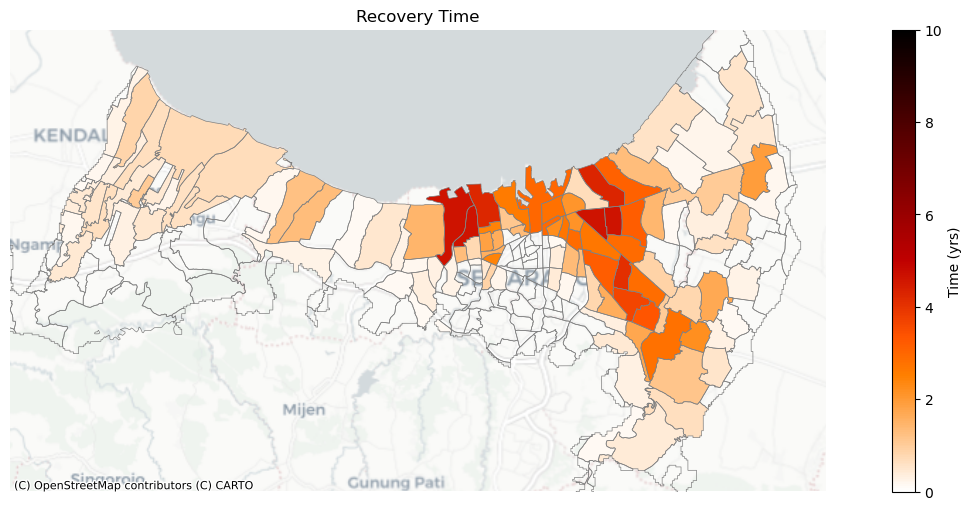

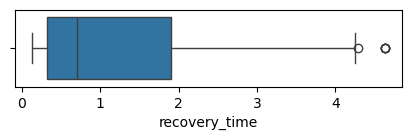

In [28]:
fig, ax = plt.subplots(figsize=figsize)
filtered_impacts.plot(
    ax=ax,
    column='recovery_time',
    cmap=cmap,
    vmin=0,
    vmax=10,
    legend=True,
    legend_kwds={"label": "Time (yrs)"},
    missing_kwds={"color": (0,0,0,0), "edgecolor": "red", "hatch": "////", "label": "Missing values"})
ax.set_title('Recovery Time')
improve_axis(ax)

fig, ax = plt.subplots(figsize=(5,1))
sns.boxplot(data=filtered_impacts, x='recovery_time', ax=ax)

Compare damages to structure, EW damages to structure and wellbeing losses

In [29]:
filtered_impacts.head(3)
filtered_impacts.to_excel('Impacts_aggregated_2045_CMIP6_SSP2_4.5_Current_Demo1_DESA_wellbeing_95.xlsx', index=False)

Text(0.5, 1.0, 'Wellbeing Losses')

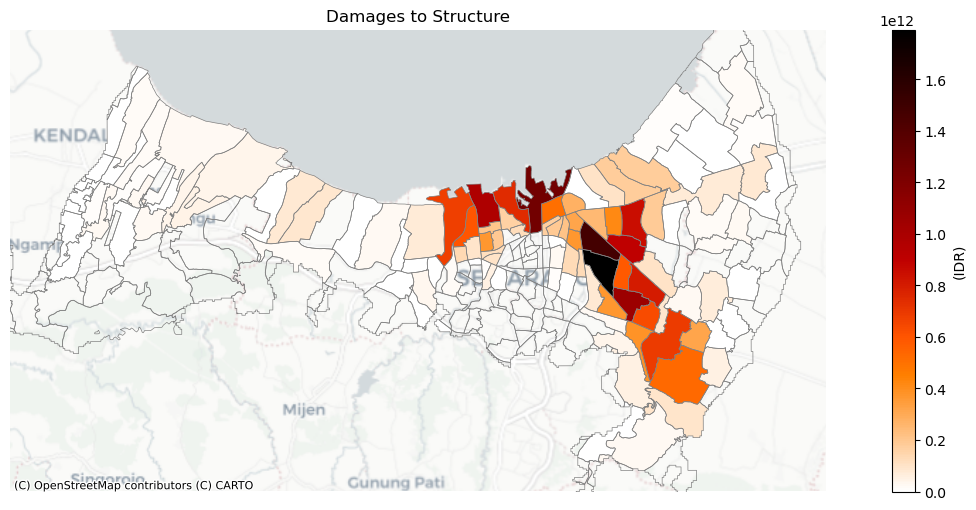

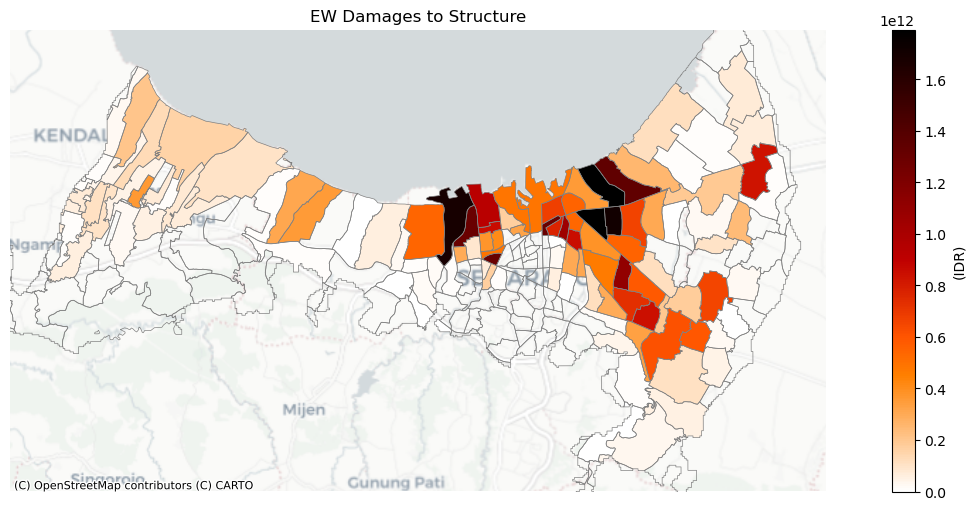

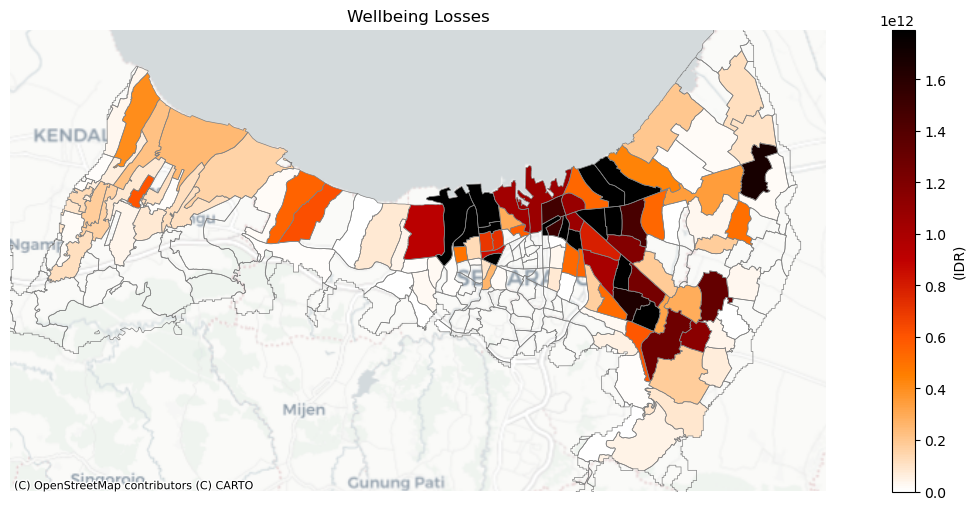

In [30]:
# enforce same vmax
vmax = min(filtered_impacts['Damage: Structure'].max(), filtered_impacts['Equity Weighted Loss'].max(), filtered_impacts['Wellbeing Loss'].max())
vmin=0

fig, ax = plt.subplots(figsize=figsize)
filtered_impacts.plot(
    ax=ax,
    column='Damage: Structure',
    cmap=cmap,
    vmin=0, 
    legend=True,
    legend_kwds={"label": f"({currency})"}
    )
improve_axis(ax)
ax.set_title('Damages to Structure')

fig, ax = plt.subplots(figsize=figsize)
filtered_impacts.plot(
    ax=ax,
    column='Equity Weighted Loss',
    cmap=cmap,
    vmin=0,
    vmax=vmax,
    legend=True,
    legend_kwds={"label": f"({currency})"}
    )
improve_axis(ax)
ax.set_title('EW Damages to Structure')

fig, ax = plt.subplots(figsize=figsize)
filtered_impacts.plot(
    ax=ax,
    column='Wellbeing Loss',
    cmap=cmap,
    vmin=0,
    vmax=vmax,
    legend=True,
    legend_kwds={"label": f"({currency})"},
    missing_kwds={"color": (0,0,0,0), "edgecolor": "red", "hatch": "////", "label": "Missing values"}
    )
improve_axis(ax)
ax.set_title('Wellbeing Losses')

### 5.4 Socioeconomic Resilience

In [ ]:
filtered_impacts['SR'] = filtered_impacts['Asset Loss'] / filtered_impacts['Wellbeing Loss']

fig, ax = plt.subplots(figsize=figsize)
filtered_impacts.plot(
    ax=ax,
    column='SR',
    cmap=cmap,
    vmin=0,
    vmax=1,
    legend=True,
    legend_kwds={"label": "(-)"},
    missing_kwds={"color": (0,0,0,0), "edgecolor": "red", "hatch": "////", "label": "Missing values"}
    )
improve_axis(ax)
ax.set_title('Socioeconomic Resilience')